# Project Navigation Guidelines

In [20]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)
'''
None

# Trial Description

In [45]:
exp = 1
trial = 1
'''
Trial 1 : 
Algorithms use Vote mechanic.
Resampling done within time period of 2s.
'''
None

# Core Libraries

In [13]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Exploratory Data Analysis

# Prepare/Load Relevant Dataset

In [14]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E1_All_Raw_130320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Label']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Label
0      13/3/20   17:19:27   0x0007   177     A
1      13/3/20   17:19:27   0x0006   177     A
2      13/3/20   17:19:27   0x0002   181     A
3      13/3/20   17:19:27   0x000A   180     A
4      13/3/20   17:19:28   0x0005   177     A
...        ...        ...      ...   ...   ...
16311  13/3/20   18:33:51   0x000B   197     D
16312  13/3/20   18:33:51   0x0008   180     D
16313  13/3/20   18:33:51   0x0004   182     D
16314  13/3/20   18:33:52   0x000A   180     D
16315  13/3/20   18:33:52   0x0006   177     D

[16316 rows x 5 columns]


In [15]:
# Resample/Reshape Dataset

In [16]:
# Preparation for Date/Time Differences
# ----------------------------------------

# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Label']]
print(readings.head(15))

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Label", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Label"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E1_resampled_T1.csv')
    print("FILE WRITTEN")

pivoted_readings.head()

2020-03-13
0:00:00
16315
    DatetimeSec      ID2  RSSI Label
0       62367.0   0x0007   177     A
1       62367.0   0x0006   177     A
2       62367.0   0x0002   181     A
3       62367.0   0x000A   180     A
4       62368.0   0x0005   177     A
5       62368.0   0x0003   188     A
6       62368.0   0x0001   186     A
7       62368.0   0x0004   177     A
8       62369.0   0x0007   177     A
9       62369.0   0x000A   177     A
10      62369.0   0x0002   193     A
11      62370.0   0x0003   187     A
12      62370.0   0x0001   185     A
13      62370.0   0x0005   177     A
14      62370.0   0x0004   177     A
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16311    0.0
16312    0.0
16313    0.0
16314    0.0
16315    0.0
Name: DatetimeSec, Length: 16316, dtype: float64
FILE WRITTEN


,ID2,1,2,3,4,5,6,7,8,9,10,11
DatetimeSec,Label,,,,,,,,,,,
0.0,A,186.0,181.0,188.0,177.0,177.0,177.0,177.0,0.0,0.0,180.0,0.0
1.0,A,185.0,193.0,187.0,177.0,177.0,0.0,177.0,0.0,0.0,177.0,0.0
2.0,A,0.0,199.0,184.0,177.0,0.0,0.0,177.0,177.0,0.0,187.0,181.0
3.0,A,178.0,192.0,179.0,0.0,180.0,181.0,0.0,178.0,0.0,184.0,181.0
4.0,A,185.0,191.0,181.0,177.0,178.0,0.0,0.0,178.0,0.0,183.0,180.0


In [17]:
resampledDS = pd.read_csv('E1_resampled_T1.csv')
tempSeries = resampledDS['Label']
resampledDS = resampledDS.drop(columns=['Label', 'DatetimeSec'])
resampledDS["Label"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_labels = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)


# #dataset.iloc[rowrange, columnrange]
X = ips_data.to_numpy()
y = ips_labels.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True,test_size=0.3) 
y_train = y_train.reshape(len(y_train),)

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
print("estimated k value: ", k_value_rootN)
print("X_test: ", X_test)
print("y_test: ", y_test)

estimated k value:  38
X_test:  [[  0.  177.  177.  ...   0.  180.  193. ]
 [183.  190.  193.  ...   0.  177.  177. ]
 [177.    0.    0.  ...   0.  180.  191. ]
 ...
 [177.  177.  177.  ...   0.  185.5 191. ]
 [185.  194.  198.  ...   0.  184.  177. ]
 [185.  191.  194.  ...   0.  187.  178. ]]
y_test:  [['D']
 ['B']
 ['C']
 ['D']
 ['B']
 ['C']
 ['A']
 ['D']
 ['C']
 ['A']
 ['A']
 ['D']
 ['C']
 ['C']
 ['B']
 ['B']
 ['D']
 ['D']
 ['A']
 ['B']
 ['D']
 ['A']
 ['A']
 ['C']
 ['D']
 ['D']
 ['A']
 ['C']
 ['D']
 ['D']
 ['A']
 ['D']
 ['C']
 ['A']
 ['B']
 ['A']
 ['C']
 ['D']
 ['D']
 ['C']
 ['A']
 ['A']
 ['D']
 ['B']
 ['A']
 ['A']
 ['B']
 ['A']
 ['B']
 ['B']
 ['A']
 ['D']
 ['B']
 ['D']
 ['D']
 ['B']
 ['B']
 ['B']
 ['C']
 ['C']
 ['C']
 ['A']
 ['A']
 ['D']
 ['A']
 ['C']
 ['D']
 ['C']
 ['C']
 ['B']
 ['C']
 ['C']
 ['D']
 ['A']
 ['B']
 ['A']
 ['B']
 ['A']
 ['A']
 ['B']
 ['D']
 ['A']
 ['C']
 ['B']
 ['A']
 ['D']
 ['A']
 ['B']
 ['A']
 ['B']
 ['B']
 ['C']
 ['A']
 ['A']
 ['B']
 ['B']
 ['D']
 ['D']
 ['B']
 [

# Parameter Optimisation

In [18]:
# k_range = list(range(1, 31))
# print("k_range: ", k_range)

# classifier = KNeighborsClassifier()

# param_grid = dict(n_neighbors=k_range)
# print("param_grid: ", param_grid)

# grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

# grid.fit(X,y)
# print("best_estimator: ", grid.best_estimator_)

# KNN Algorithm

In [19]:
n_samples = 20

#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

In [20]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [21]:
# TEST OUTPUT

outArray = []
for i in range(n_samples):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[0.0, 177.0, 177.0, 0.0, 185.0, 183.0, 177.0, ...",[D],"[([0.0, 177.0, 177.0, 0.0, 185.0, 184.0, 177.0..."
1,1,"[183.0, 190.0, 193.0, 0.0, 180.0, 185.0, 177.0...",[B],"[([187.0, 190.0, 193.0, 0.0, 179.0, 185.0, 177..."
2,2,"[177.0, 0.0, 0.0, 179.0, 185.0, 0.0, 177.0, 17...",[C],"[([177.0, 0.0, 0.0, 182.0, 184.0, 0.0, 177.0, ..."
3,3,"[0.0, 179.0, 177.0, 0.0, 185.0, 184.0, 177.0, ...",[D],"[([177.0, 177.0, 177.0, 0.0, 185.0, 181.0, 179..."
4,4,"[184.0, 191.0, 193.0, 177.0, 0.0, 178.0, 0.0, ...",[B],"[([184.0, 190.0, 194.0, 177.0, 0.0, 178.0, 0.0..."


In [22]:
from collections import Counter

#Function enables voting mechanic in KNN for Classification according to majority class vote
def vote(neighbors):
    class_counter = Counter() #A Counter is a dict subclass for counting hashable objects. 
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #neighbor[2] -> label for neighbor(s)
    return class_counter.most_common(1)[0][0]

In [48]:
k_value_knn = 1
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    print("index: ", i, 
          ", result of vote: ", vote(neighbors), 
          ", label: ", y_train[i], 
          ", data: ", X_train[i])

index:  0 , result of vote:  D , label:  D , data:  [  0. 177. 177. 185.   0.   0. 177.   0.   0. 181. 190.]
index:  1 , result of vote:  B , label:  A , data:  [186. 190. 181. 177.   0. 181.   0.   0.   0. 177. 177.]
index:  2 , result of vote:  D , label:  B , data:  [184. 191. 193.   0.   0. 177.   0. 177.   0. 187. 179.]
index:  3 , result of vote:  C , label:  D , data:  [  0. 177. 177. 185.   0. 184. 177.   0.   0. 180. 192.]
index:  4 , result of vote:  B , label:  A , data:  [182. 189. 179. 177. 184. 177. 181. 177.   0. 190. 180.]


In [44]:
#Function returns vote 'probability' - i.e. distribution/percentage majority vote
def vote_prob(neighbors):
    class_counter = Counter() # Counter object - https://docs.python.org/2/library/collections.html
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #add to count of target (class)
        
    # aggregates into tuples ~ zip(*iterables), 
    # Return a list of the n most common elements and their counts from the most common to the least.    
    labels, votes = zip(*class_counter.most_common()) #returns list of sorted most common [labels], [votes]
    #print("L|V: ", labels, votes)
    #print("Class Counter: ", class_counter.most_common)
    winner = class_counter.most_common(1)[0][0]       #majority label
    votes4winner = class_counter.most_common(1)[0][1] #majority vote count
    return winner, votes4winner/sum(votes)            #returns majority label, majority proportion

In [25]:
writeKNN = True
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'vote_result', 'vote_prob', 'label', 'prediction'])

indexArray = []
dataArray = []
voteArray = []
probArray = []
labelArray = []
predArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    indexArray.append(i)
    dataArray.append(X_test[i])
    voteArray.append(vote(neighbors))
    probArray.append(vote_prob(neighbors))
    labelArray.append(y_test[i][0])
    predArray.append("CORRECT" if (vote(neighbors) == y_test[i]) else "WRONG")
#     print("index: ", i, 
#           ", result of vote: ", vote(neighbors), 
#           ", vote_prob: ", vote_prob(neighbors), 
#           ", label: ", y_test[i], "prediction: "
#         "CORRECT" if (vote(neighbors) == y_test[i]) else "WRONG"
#           ", data: ", X_test[i])

resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['vote_result'] = voteArray
resultsKNN['vote_prob'] = probArray
resultsKNN['label'] = labelArray 
resultsKNN['prediction'] = predArray

if (writeKNN == True):
    resultsKNN.to_csv('E1_KNN_T1_k'+str(k_value_knn)+'.csv', index=False)
    print("File "+'E1_KNN_T1_k'+str(k_value_knn)+'.csv'+" has been written.")
resultsKNN.head(20)

File E1_KNN_T1_k1.csv has been written.


,index,data,vote_result,vote_prob,label,prediction
0,0,"[0.0, 177.0, 177.0, 0.0, 185.0, 183.0, 177.0, ...",D,"(D, 1.0)",D,CORRECT
1,1,"[183.0, 190.0, 193.0, 0.0, 180.0, 185.0, 177.0...",B,"(B, 1.0)",B,CORRECT
2,2,"[177.0, 0.0, 0.0, 179.0, 185.0, 0.0, 177.0, 17...",D,"(D, 1.0)",C,WRONG
3,3,"[0.0, 179.0, 177.0, 0.0, 185.0, 184.0, 177.0, ...",C,"(C, 1.0)",D,WRONG
4,4,"[184.0, 191.0, 193.0, 177.0, 0.0, 178.0, 0.0, ...",B,"(B, 1.0)",B,CORRECT
5,5,"[177.0, 181.0, 178.0, 190.0, 0.0, 0.0, 0.0, 0....",C,"(C, 1.0)",C,CORRECT
6,6,"[181.0, 187.0, 179.0, 178.0, 185.0, 0.0, 180.0...",A,"(A, 1.0)",A,CORRECT
7,7,"[0.0, 177.0, 177.0, 186.0, 0.0, 0.0, 0.0, 177....",D,"(D, 1.0)",D,CORRECT
8,8,"[177.0, 180.0, 178.0, 189.0, 191.0, 0.0, 0.0, ...",C,"(C, 1.0)",C,CORRECT
9,9,"[181.0, 189.0, 179.0, 178.0, 179.0, 0.0, 181.0...",A,"(A, 1.0)",A,CORRECT


# Rank (Harmonic) Weighted KNN

In [26]:
#Function for weighted KNN voting mechanic; harmonic weights based on ranking of datapoint (vote += 1/rank)
def vote_harmonic_weights(neighbors, all_results=True):
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        #weighted count of votes
#         print("Index: ", index)
#         print(class_counter[neighbors[index][2]])
#         print(neighbors[index][2][0])
        class_counter[neighbors[index][2][0]] += ( 1/(index+1) ) #add (1/ neighbour_rank) for each vote; index+1 = neighbour_rank
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if all_results:
        total = sum(class_counter.values(), 0.0)
        
        for key in class_counter:
             class_counter[key] /= total #returns vote proportion for key ("class") in class_counter
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [27]:
k_value_rwknn = 1
writeRWKNN = True
resultsRWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rwknn, 
                              distance=euclideanDistance)
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteArray.append(vote_harmonic_weights(neighbors,all_results=True)[0])
    predArray.append("CORRECT" if (vote_harmonic_weights(neighbors,all_results=True)[0] == y_test[i]) else "WRONG")
    
#     print("index:", i, 
#           ",result of vote: ", 
#           vote_harmonic_weights(neighbors,
#                                 all_results=True), 
#           ",label: ", y_test[i], 
#         ",prediction: ",
#         "CORRECT" if ( vote_harmonic_weights(neighbors,
#                                 all_results=True)[0] == y_test[i]) else "WRONG")
    
resultsRWKNN['index'] = indexArray
resultsRWKNN['data'] = dataArray
resultsRWKNN['label'] = labelArray
resultsRWKNN['vote_result'] = voteArray
resultsRWKNN['prediction'] = predArray

if (writeRWKNN == True):
    resultsRWKNN.to_csv('E1_RWKNN_T1_k'+str(k_value_rwknn)+'.csv', index=False)
    print("File "+'E1_RWKNN_T1_k'+str(k_value_rwknn)+'.csv'+" has been written.")
resultsRWKNN


File E1_RWKNN_T1_k1.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[0.0, 177.0, 177.0, 0.0, 185.0, 183.0, 177.0, ...",[D],D,CORRECT
1,1,"[183.0, 190.0, 193.0, 0.0, 180.0, 185.0, 177.0...",[B],B,CORRECT
2,2,"[177.0, 0.0, 0.0, 179.0, 185.0, 0.0, 177.0, 17...",[C],D,WRONG
3,3,"[0.0, 179.0, 177.0, 0.0, 185.0, 184.0, 177.0, ...",[D],C,WRONG
4,4,"[184.0, 191.0, 193.0, 177.0, 0.0, 178.0, 0.0, ...",[B],B,CORRECT
...,...,...,...,...,...
609,609,"[187.0, 0.0, 193.0, 177.0, 0.0, 185.0, 177.0, ...",[B],B,CORRECT
610,610,"[0.0, 0.0, 181.0, 0.0, 185.0, 0.0, 177.0, 0.0,...",[C],C,CORRECT
611,611,"[177.0, 177.0, 177.0, 180.0, 185.0, 0.0, 178.0...",[C],C,CORRECT
612,612,"[185.0, 194.0, 198.0, 177.0, 0.0, 0.0, 0.0, 0....",[B],B,CORRECT


# Distance Weighted KNN

In [37]:
#Function for distance weighted KNN voting mechanic; weight based on euclidean distance (vote += 1/distance)
def vote_distance_weights(neighbors, all_results=True):
    debug = False
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        dist = neighbors[index][1]
        label = neighbors[index][2]
        if (debug == True):
            print("Neighbour record: Label is ", label, "with distance ", dist)
            print("Existing count for ", label, "is ", class_counter[label[0]])
            print("Adding count by ", (1 / (1 if dist == 0 else dist)))
        class_counter[label[0]] += (1 / (1 if dist == 0 else dist)) #sensitivity of distance weight can be adjusted here.
        
        
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if (debug == True):
        print("COUNTER: ", class_counter)
        print("----------------------------------------------------")
        print("winner: ", winner)
        print("votes: ", votes4winner)
    
    if all_results:
        total = sum(class_counter.values(), 0.0)
        
        for key in class_counter:
            class_counter[key] /= total
        if (debug == True):
            print("total votes: ", total)
            print("AFTER NORMALISING: ", class_counter)
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [50]:
k_value_dwknn = 1
testRange = 5
for i in range(testRange):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    res = vote_distance_weights(neighbors, all_results=True)
    
    print("index: ", i, 
      ", result of vote: ", res,
    ",label: ", y_test[i], 
    ",prediction: ",
    "CORRECT" if ( res[0] == y_test[i]) else "WRONG")
    print("\n\n")


index:  0 , result of vote:  ('D', [('D', 1.0)]) ,label:  ['D'] ,prediction:  CORRECT



index:  1 , result of vote:  ('B', [('B', 1.0)]) ,label:  ['B'] ,prediction:  CORRECT



index:  2 , result of vote:  ('D', [('D', 1.0)]) ,label:  ['C'] ,prediction:  WRONG



index:  3 , result of vote:  ('C', [('C', 1.0)]) ,label:  ['D'] ,prediction:  WRONG



index:  4 , result of vote:  ('B', [('B', 1.0)]) ,label:  ['B'] ,prediction:  CORRECT





In [52]:
k_value_dwknn = k_value_rootN
writeDWKNN = True
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

# need to normalise distance!!!!

for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    vote_distance_weights(neighbors, all_results=True)
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteDistWRes = vote_distance_weights(neighbors,all_results=True)[0]
    voteArray.append(voteDistWRes)
    predArray.append("CORRECT" if (voteDistWRes == y_test[i]) else "WRONG")

#     print("index: ", i, 
#           ", result of vote: ", vote_distance_weights(neighbors,
#                                                       all_results=True),
#         ",label: ", y_test[i], 
#         ",prediction: ",
#         "CORRECT" if ( vote_harmonic_weights(neighbors,
#                                 all_results=True)[0] == y_test[i]) else "WRONG")
    
resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['label'] = labelArray
resultsDWKNN['vote_result'] = voteArray
resultsDWKNN['prediction'] = predArray


if (writeDWKNN == True):
    resultsDWKNN.to_csv('E1_DWKNN_T1_k'+str(k_value_dwknn)+'.csv', index=False) 
    print("File "+'E1_DWKNN_T1_k'+str(k_value_dwknn)+'.csv'+" has been written.")
resultsDWKNN



File E1_DWKNN_T1_k38.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[0.0, 177.0, 177.0, 0.0, 185.0, 183.0, 177.0, ...",[D],D,CORRECT
1,1,"[183.0, 190.0, 193.0, 0.0, 180.0, 185.0, 177.0...",[B],B,CORRECT
2,2,"[177.0, 0.0, 0.0, 179.0, 185.0, 0.0, 177.0, 17...",[C],C,CORRECT
3,3,"[0.0, 179.0, 177.0, 0.0, 185.0, 184.0, 177.0, ...",[D],D,CORRECT
4,4,"[184.0, 191.0, 193.0, 177.0, 0.0, 178.0, 0.0, ...",[B],B,CORRECT
...,...,...,...,...,...
609,609,"[187.0, 0.0, 193.0, 177.0, 0.0, 185.0, 177.0, ...",[B],B,CORRECT
610,610,"[0.0, 0.0, 181.0, 0.0, 185.0, 0.0, 177.0, 0.0,...",[C],D,WRONG
611,611,"[177.0, 177.0, 177.0, 180.0, 185.0, 0.0, 178.0...",[C],C,CORRECT
612,612,"[185.0, 194.0, 198.0, 177.0, 0.0, 0.0, 0.0, 0....",[B],B,CORRECT


# Data Analysis via Visualisation

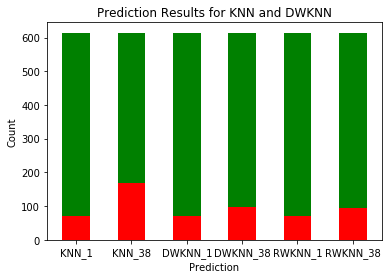

<Figure size 2160x2160 with 0 Axes>

In [54]:

KNN_kcomp1 = pd.read_csv('E1_KNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
KNN_kcomp1_results = KNN_kcomp1.groupby('prediction').count().data
count_correct_KNN_kcomp1 = (KNN_kcomp1_results.CORRECT)
count_wrong_KNN_kcomp1 = (KNN_kcomp1_results.WRONG)

DWKNN_kcomp1 = pd.read_csv('E1_DWKNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
DWKNN_kcomp1_results = DWKNN_kcomp1.groupby('prediction').count().data
count_correct_DWKNN_kcomp1 = (DWKNN_kcomp1_results.CORRECT)
count_wrong_DWKNN_kcomp1 = (DWKNN_kcomp1_results.WRONG)

RWKNN_kcomp1 = pd.read_csv('E1_RWKNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
RWKNN_kcomp1_results = RWKNN_kcomp1.groupby('prediction').count().data
count_correct_RWKNN_kcomp1 = (RWKNN_kcomp1_results.CORRECT)
count_wrong_RWKNN_kcomp1 = (RWKNN_kcomp1_results.WRONG)

KNN_kcomp2 = pd.read_csv('E1_KNN_T1_k38.csv')
#count number of CORRECT/ WRONG.
KNN_kcomp2_results = KNN_kcomp2.groupby('prediction').count().data
count_correct_KNN_kcomp2 = (KNN_kcomp2_results.CORRECT)
count_wrong_KNN_kcomp2 = (KNN_kcomp2_results.WRONG)

RWKNN_kcomp2 = pd.read_csv('E1_RWKNN_T1_k38.csv')
#count number of CORRECT/ WRONG.
RWKNN_kcomp2_results = RWKNN_kcomp2.groupby('prediction').count().data
count_correct_RWKNN_kcomp2 = (RWKNN_kcomp2_results.CORRECT)
count_wrong_RWKNN_kcomp2 = (RWKNN_kcomp2_results.WRONG)

DWKNN_kcomp2 = pd.read_csv('E1_DWKNN_T1_k38.csv')
#count number of CORRECT/ WRONG.
DWKNN_kcomp2_results = DWKNN_kcomp2.groupby('prediction').count().data
count_correct_DWKNN_kcomp2 = (DWKNN_kcomp2_results.CORRECT)
count_wrong_DWKNN_kcomp2 = (DWKNN_kcomp2_results.WRONG)


# create plot
n_groups = 1 # number of groups
fig, ax = plt.subplots()
index = np.arange(n_groups) # x location for groups
bar_width = 1

#first bar - rects1+rects2
rects1 = plt.bar(index, count_correct_KNN_kcomp1, bar_width, bottom = count_wrong_KNN_kcomp1, 
#                  label='KNN_1_CORRECT', 
                 color = 'g')
rects2 = plt.bar(index, count_wrong_KNN_kcomp1, bar_width, 
                 color = 'r')

rects3 = plt.bar(index + 2*bar_width, count_correct_KNN_kcomp2, bar_width, bottom = count_wrong_KNN_kcomp2, 
                 color = 'g')
rects4 = plt.bar(index + 2*bar_width, count_wrong_KNN_kcomp2, bar_width, 
                 color = 'r')

rects5 = plt.bar(index + 4*bar_width, count_correct_DWKNN_kcomp1, bar_width, bottom = count_wrong_DWKNN_kcomp1, 
                 color = 'g')
rects6 = plt.bar(index + 4*bar_width, count_wrong_DWKNN_kcomp1, bar_width,
                 color = 'r')

rects7 = plt.bar(index + 6*bar_width, count_correct_DWKNN_kcomp2, bar_width, bottom = count_wrong_DWKNN_kcomp2,
                 color = 'g')
rects8 = plt.bar(index + 6*bar_width, count_wrong_DWKNN_kcomp2, bar_width,
                 color = 'r')

rects9 = plt.bar(index + 8*bar_width, count_correct_RWKNN_kcomp1, bar_width, bottom = count_wrong_RWKNN_kcomp1,  
                 color = 'g')
rects10 = plt.bar(index + 8*bar_width, count_wrong_RWKNN_kcomp1, bar_width, 
                 color = 'r')

rects9 = plt.bar(index + 10*bar_width, count_correct_RWKNN_kcomp2, bar_width, bottom = count_wrong_RWKNN_kcomp2,  
                 color = 'g')
rects10 = plt.bar(index + 10*bar_width, count_wrong_RWKNN_kcomp2, bar_width, 
                 color = 'r')

plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Prediction Results for KNN and DWKNN')
plt.xticks([0,2*bar_width, 4*bar_width, 6*bar_width, 8*bar_width, 10*bar_width], ["KNN_1", "KNN_38", "DWKNN_1", "DWKNN_38", "RWKNN_1", "RWKNN_38"])
# plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.figure(figsize=(30,30))
plt.show()

In [55]:
KNNsummary1 = KNN_kcomp1.groupby('prediction').count().data
RWKNNsummary1 = RWKNN_kcomp1.groupby('prediction').count().data
DWKNNsummary1 = DWKNN_kcomp1.groupby('prediction').count().data

KNNsummary2 = KNN_kcomp2.groupby('prediction').count().data
RWKNNsummary2 = RWKNN_kcomp2.groupby('prediction').count().data
DWKNNsummary2 = DWKNN_kcomp2.groupby('prediction').count().data

print("--------------")
print("Summary")
print("--------------")
print("KNNcomp1: \n", KNNsummary1)
print("Accuracy: ", KNN_kcomp1_results.CORRECT / 
      (KNN_kcomp1_results.CORRECT + KNN_kcomp1_results.WRONG))
print("\nKNNcomp2: \n", KNNsummary2)
print("Accuracy: ", KNN_kcomp2_results.CORRECT / 
      (KNN_kcomp2_results.CORRECT + KNN_kcomp2_results.WRONG))
print("--------------")
print("RWKNNcomp1: \n", RWKNNsummary1)
print("Accuracy: ", RWKNN_kcomp1_results.CORRECT / 
      (RWKNN_kcomp1_results.CORRECT + RWKNN_kcomp1_results.WRONG))
print("\nRWKNNcomp2: \n", RWKNNsummary2)
print("Accuracy: ", RWKNN_kcomp2_results.CORRECT / 
      (RWKNN_kcomp2_results.CORRECT + RWKNN_kcomp2_results.WRONG))
print("--------------")
print("DWKNNcomp1: \n", DWKNNsummary1)
print("Accuracy: ", DWKNN_kcomp1_results.CORRECT / 
      (DWKNN_kcomp1_results.CORRECT + DWKNN_kcomp1_results.WRONG))
print("\nDWKNNcomp2: \n", DWKNNsummary2)
print("Accuracy: ", DWKNN_kcomp2_results.CORRECT / 
      (DWKNN_kcomp2_results.CORRECT + DWKNN_kcomp2_results.WRONG))

--------------
Summary
--------------
KNNcomp1: 
 prediction
CORRECT    543
WRONG       71
Name: data, dtype: int64
Accuracy:  0.8843648208469055

KNNcomp2: 
 prediction
CORRECT    444
WRONG      170
Name: data, dtype: int64
Accuracy:  0.7231270358306189
--------------
RWKNNcomp1: 
 prediction
CORRECT    543
WRONG       71
Name: data, dtype: int64
Accuracy:  0.8843648208469055

RWKNNcomp2: 
 prediction
CORRECT    520
WRONG       94
Name: data, dtype: int64
Accuracy:  0.8469055374592834
--------------
DWKNNcomp1: 
 prediction
CORRECT    543
WRONG       71
Name: data, dtype: int64
Accuracy:  0.8843648208469055

DWKNNcomp2: 
 prediction
CORRECT    517
WRONG       97
Name: data, dtype: int64
Accuracy:  0.8420195439739414
